# 能動学習 (Active Learning) デモ

## 概要
**能動学習**とは、モデル自身が「次にどのデータを学習すべきか」を選ぶ手法です。

通常の機械学習ではランダムにデータを集めますが、能動学習では**モデルの予測が不確実な領域**を優先的にサンプリングすることで、少ないデータで効率的に学習できます。

### このデモで体験すること
1. 少数の初期データでサロゲートモデル（ガウス過程回帰）を構築
2. 能動学習ループ：不確実性が高い点を逐次追加
3. ランダムサンプリングとの性能比較

### 用語
| 用語 | 説明 |
|------|------|
| サロゲートモデル | シミュレーションの代替となる近似モデル |
| ガウス過程回帰 (GPR) | 予測値と**不確実性**を同時に出力できるモデル |
| 獲得関数 | 次にどの点をサンプリングすべきかを決める基準 |
| 候補プール | ラベル（出力値）をまだ取得していないデータ点の集合 |

## 1. 準備

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pathlib import Path

# ─── 日本語フォント設定 ──────────────────────────────────────────────────────
# Windows 環境: Yu Gothic を優先。見つからない場合は英語表示にフォールバック
import matplotlib.font_manager as _fm
_jp_candidates = ["Yu Gothic", "Meiryo", "BIZ UDGothic", "MS Gothic"]
_available = {f.name for f in _fm.fontManager.ttflist}
_jp_font = next((f for f in _jp_candidates if f in _available), None)

if _jp_font:
    matplotlib.rcParams["font.family"] = _jp_font
    print(f"[font] Japanese font set: {_jp_font}")
else:
    print("[font] No Japanese font found — labels will be shown in English")

matplotlib.rcParams["axes.unicode_minus"] = False  # マイナス記号の文字化け防止

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 10

DATA_DIR = Path("data")

[font] Japanese font set: Yu Gothic


## 2. データの読み込みと確認

`generate_dataset.py` で生成した以下のデータを使用します：
- **初期サンプル** (20点): モデルの初期学習に使用
- **候補プール** (500点): 能動学習で選択する候補
- **グリッド** (100x100): 真の関数の可視化・評価用

In [39]:
# データ読み込み
grid = np.load(DATA_DIR / "grid.npz")
initial = np.load(DATA_DIR / "initial_samples.npz")
pool = np.load(DATA_DIR / "candidate_pool.npz")

X1_grid, X2_grid, Y_grid = grid["X1"], grid["X2"], grid["Y"]
X_grid_flat = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
y_grid_flat = Y_grid.ravel()

print(f"初期サンプル: {initial['X'].shape[0]} 点")
print(f"候補プール:   {pool['X'].shape[0]} 点")
print(f"評価グリッド: {X1_grid.shape[0]}x{X1_grid.shape[1]} = {y_grid_flat.shape[0]} 点")

初期サンプル: 20 点
候補プール:   500 点
評価グリッド: 100x100 = 10000 点


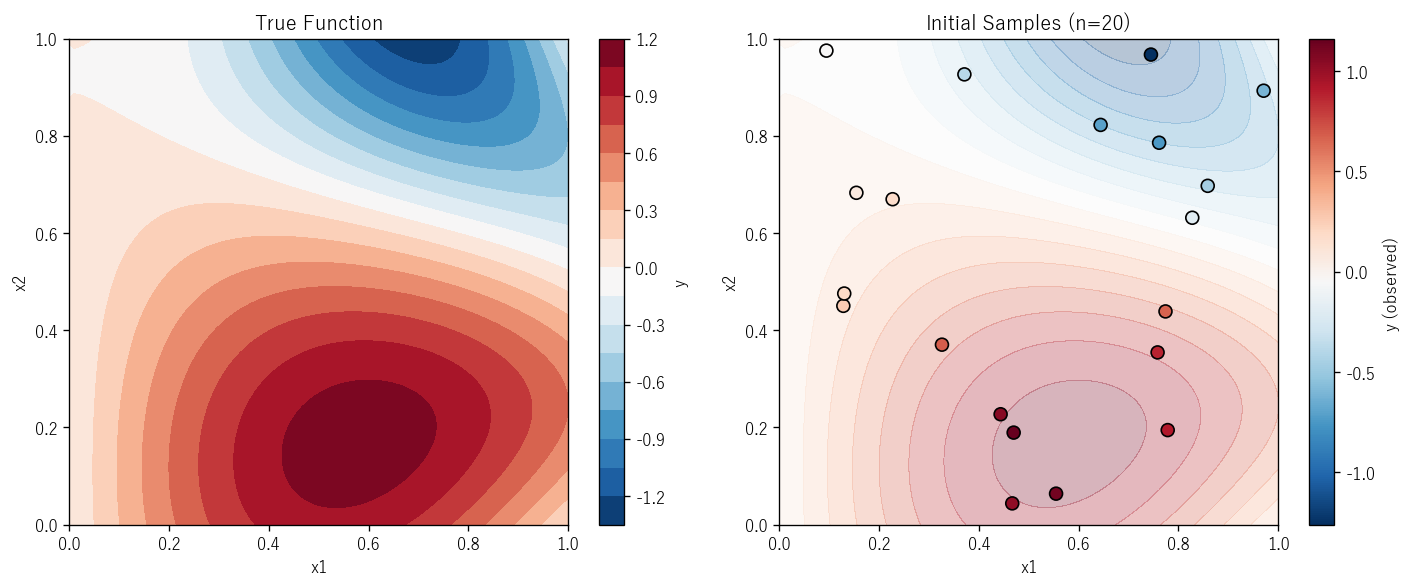

In [40]:
# 真の関数と初期サンプルの可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
c = ax.contourf(X1_grid, X2_grid, Y_grid, levels=20, cmap="RdBu_r")
fig.colorbar(c, ax=ax, label="y")
ax.set_title("True Function")
ax.set_xlabel("x1"); ax.set_ylabel("x2")

ax = axes[1]
ax.contourf(X1_grid, X2_grid, Y_grid, levels=20, cmap="RdBu_r", alpha=0.3)
sc = ax.scatter(initial["X"][:, 0], initial["X"][:, 1],
                c=initial["y"], cmap="RdBu_r", edgecolors="k", s=60, zorder=5)
fig.colorbar(sc, ax=ax, label="y (observed)")
ax.set_title(f"Initial Samples (n={initial['X'].shape[0]})")
ax.set_xlabel("x1"); ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

## 3. サロゲートモデル（ガウス過程回帰）の初期学習

ガウス過程回帰 (GPR) は、各点での**予測値**と**予測の不確実性（標準偏差）**を同時に出力します。
この不確実性こそが、能動学習で「次にどこをサンプリングすべきか」を判断する鍵です。

In [41]:
def build_gpr(X_train, y_train):
    """ガウス過程回帰モデルを構築・学習する"""
    kernel = ConstantKernel(1.0) * RBF(length_scale=0.3) + WhiteKernel(noise_level=0.01)
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        random_state=42,
    )
    gpr.fit(X_train, y_train)
    return gpr


def evaluate_model(gpr, X_eval, y_eval):
    """グリッド全体でのRMSEを計算"""
    y_pred = gpr.predict(X_eval)
    return np.sqrt(mean_squared_error(y_eval, y_pred))


def plot_gpr_state(gpr, X_train, X1_grid, X2_grid, Y_grid, title_suffix=""):
    """GPRの現在の予測と不確実性を可視化"""
    X_flat = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
    y_pred, y_std = gpr.predict(X_flat, return_std=True)
    Y_pred = y_pred.reshape(X1_grid.shape)
    Y_std = y_std.reshape(X1_grid.shape)
    Y_err = np.abs(Y_pred - Y_grid)

    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

    # 予測値
    ax = axes[0]
    c = ax.contourf(X1_grid, X2_grid, Y_pred, levels=20, cmap="RdBu_r")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=15, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title(f"GPR Prediction (n={len(X_train)})")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

    # 不確実性
    ax = axes[1]
    c = ax.contourf(X1_grid, X2_grid, Y_std, levels=20, cmap="YlOrRd")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=15, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title("Prediction Uncertainty (std)")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

    # 予測誤差
    ax = axes[2]
    c = ax.contourf(X1_grid, X2_grid, Y_err, levels=20, cmap="YlOrRd")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=15, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title("Absolute Error |pred - true|")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

    if title_suffix:
        fig.suptitle(title_suffix, fontsize=13, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

Initial RMSE: 0.1091


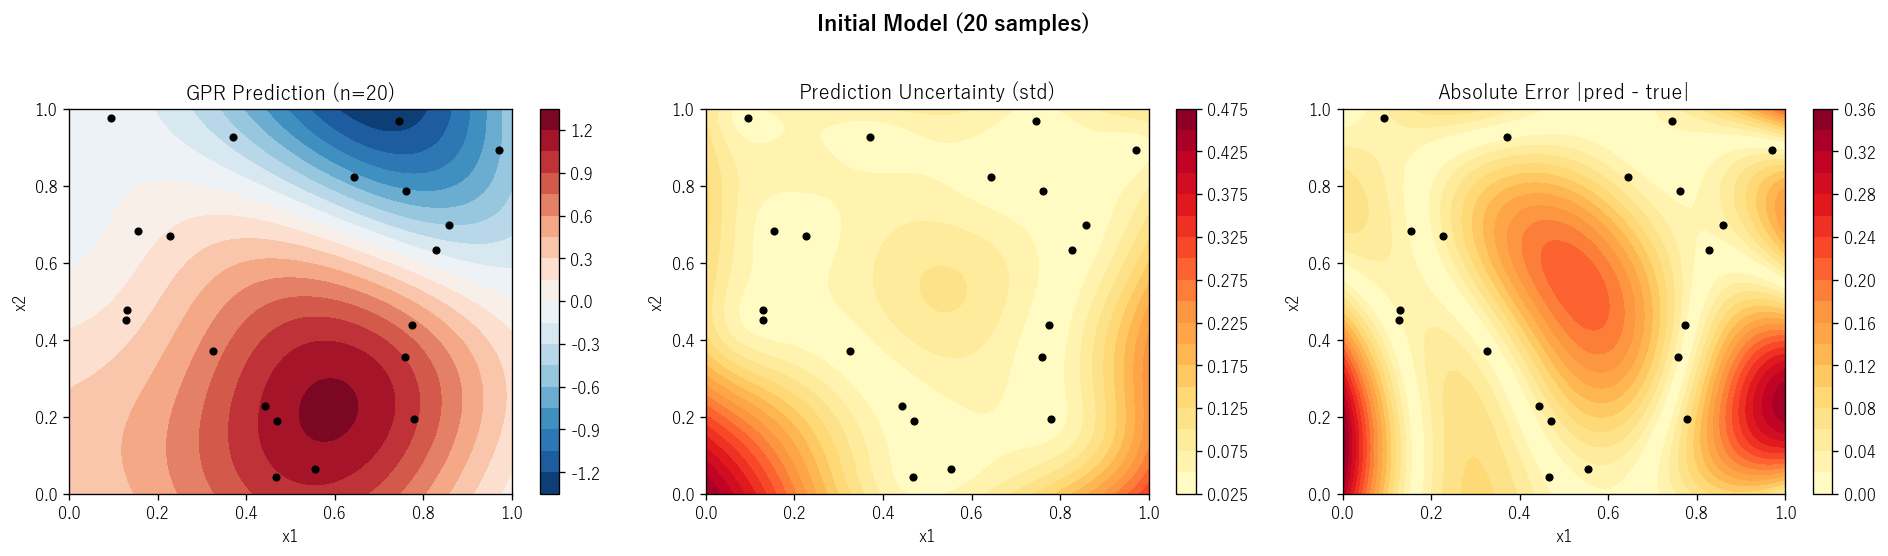

In [42]:
# 初期サンプルのみで学習
gpr_init = build_gpr(initial["X"], initial["y"])
rmse_init = evaluate_model(gpr_init, X_grid_flat, y_grid_flat)
print(f"Initial RMSE: {rmse_init:.4f}")

plot_gpr_state(gpr_init, initial["X"], X1_grid, X2_grid, Y_grid,
               title_suffix="Initial Model (20 samples)")

## 4. 能動学習ループ

### 獲得関数：最大不確実性サンプリング (Uncertainty Sampling)

最もシンプルな能動学習戦略です。候補プールの中から**GPRの予測標準偏差が最大の点**を選びます。

```
次のサンプル = argmax_{x ∈ 候補プール} σ(x)
```

直感的には「モデルが最も自信のない場所」を優先的に学習する、という戦略です。

In [43]:
def active_learning_loop(X_init, y_init, X_pool, y_pool,
                         X_eval, y_eval, n_iterations=30, batch_size=1):
    """
    能動学習ループ（不確実性サンプリング）

    Parameters
    ----------
    X_init, y_init : 初期学習データ
    X_pool, y_pool : 候補プール（y_poolは「実験すれば得られる」真のラベル）
    X_eval, y_eval : 評価用データ（グリッド全体）
    n_iterations   : 能動学習の反復回数
    batch_size     : 1回に追加するサンプル数

    Returns
    -------
    history : dict（RMSE履歴、選択された点など）
    """
    X_train = X_init.copy()
    y_train = y_init.copy()
    X_remaining = X_pool.copy()
    y_remaining = y_pool.copy()

    rmse_history = []
    selected_points = []

    for i in range(n_iterations):
        # 1. GPRを学習
        gpr = build_gpr(X_train, y_train)
        rmse = evaluate_model(gpr, X_eval, y_eval)
        rmse_history.append(rmse)

        # 2. 候補プールでの不確実性を計算
        _, y_std = gpr.predict(X_remaining, return_std=True)

        # 3. 不確実性が最大の点を選択
        idx = np.argsort(y_std)[-batch_size:]

        # 4. 選択した点を学習データに追加
        selected_points.append(X_remaining[idx].copy())
        X_train = np.vstack([X_train, X_remaining[idx]])
        y_train = np.concatenate([y_train, y_remaining[idx]])

        # 5. 候補プールから除去
        X_remaining = np.delete(X_remaining, idx, axis=0)
        y_remaining = np.delete(y_remaining, idx, axis=0)

    # 最終モデルの評価
    gpr_final = build_gpr(X_train, y_train)
    rmse_history.append(evaluate_model(gpr_final, X_eval, y_eval))

    return {
        "rmse_history": rmse_history,
        "selected_points": selected_points,
        "gpr_final": gpr_final,
        "X_train_final": X_train,
        "y_train_final": y_train,
    }

In [44]:
N_ITERATIONS = 30

print(f"能動学習を実行中... ({N_ITERATIONS} iterations)")
al_result = active_learning_loop(
    initial["X"], initial["y"],
    pool["X"], pool["y"],
    X_grid_flat, y_grid_flat,
    n_iterations=N_ITERATIONS,
)
print(f"RMSE: {al_result['rmse_history'][0]:.4f} → {al_result['rmse_history'][-1]:.4f}")
print(f"学習データ: {initial['X'].shape[0]} → {al_result['X_train_final'].shape[0]} 点")

能動学習を実行中... (30 iterations)
RMSE: 0.1091 → 0.0329
学習データ: 20 → 50 点


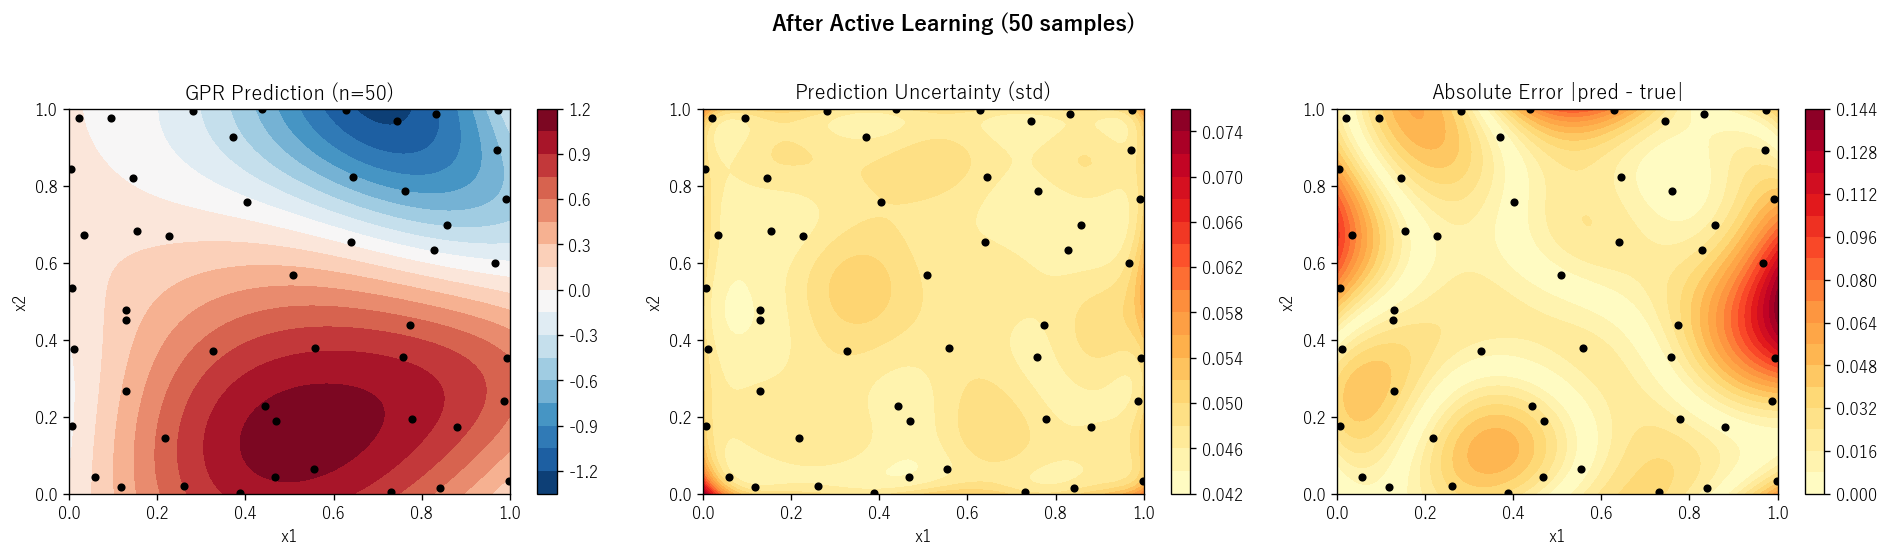

In [45]:
# 能動学習後のモデル状態を可視化
plot_gpr_state(al_result["gpr_final"], al_result["X_train_final"],
               X1_grid, X2_grid, Y_grid,
               title_suffix=f"After Active Learning ({al_result['X_train_final'].shape[0]} samples)")

### 能動学習が選んだ点の可視化

能動学習がどの順番でどの点を選んだかを確認します。初期の段階では空白地帯を、後半では複雑な領域を選ぶ傾向が見えるはずです。

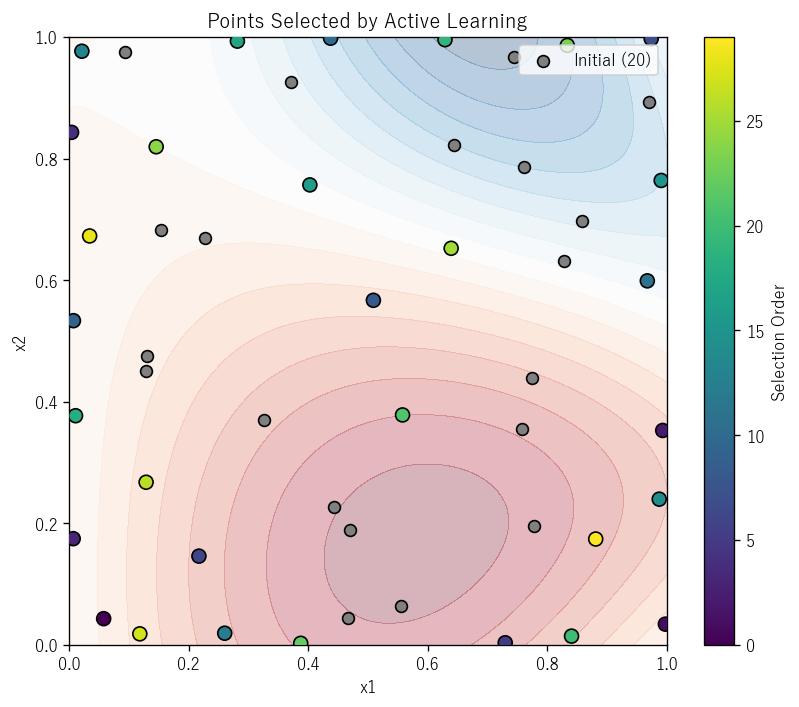

In [46]:
# 能動学習で選択された点の順序を可視化
fig, ax = plt.subplots(figsize=(7, 6))
ax.contourf(X1_grid, X2_grid, Y_grid, levels=20, cmap="RdBu_r", alpha=0.3)

# 初期サンプル
ax.scatter(initial["X"][:, 0], initial["X"][:, 1],
           c="gray", edgecolors="k", s=50, zorder=4, label="Initial (20)")

# 能動学習で選ばれた点（色で順序を表現）
selected = np.vstack(al_result["selected_points"])
order = np.arange(len(selected))
sc = ax.scatter(selected[:, 0], selected[:, 1],
                c=order, cmap="viridis", edgecolors="k", s=70, zorder=5)
cbar = fig.colorbar(sc, ax=ax, label="Selection Order")

ax.set_title("Points Selected by Active Learning")
ax.set_xlabel("x1"); ax.set_ylabel("x2")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## 5. ランダムサンプリングとの比較

能動学習の効果を示すために、同じ候補プールからランダムに点を選ぶ戦略と比較します。

In [47]:
def random_sampling_loop(X_init, y_init, X_pool, y_pool,
                         X_eval, y_eval, n_iterations=30, batch_size=1, seed=0):
    """ランダムサンプリングによるベースライン"""
    rng = np.random.default_rng(seed)
    X_train = X_init.copy()
    y_train = y_init.copy()
    X_remaining = X_pool.copy()
    y_remaining = y_pool.copy()

    rmse_history = []

    for i in range(n_iterations):
        gpr = build_gpr(X_train, y_train)
        rmse = evaluate_model(gpr, X_eval, y_eval)
        rmse_history.append(rmse)

        # ランダムに選択
        idx = rng.choice(len(X_remaining), size=batch_size, replace=False)
        X_train = np.vstack([X_train, X_remaining[idx]])
        y_train = np.concatenate([y_train, y_remaining[idx]])
        X_remaining = np.delete(X_remaining, idx, axis=0)
        y_remaining = np.delete(y_remaining, idx, axis=0)

    gpr_final = build_gpr(X_train, y_train)
    rmse_history.append(evaluate_model(gpr_final, X_eval, y_eval))

    return {
        "rmse_history": rmse_history,
        "gpr_final": gpr_final,
        "X_train_final": X_train,
    }

print(f"ランダムサンプリングを実行中... ({N_ITERATIONS} iterations)")
rand_result = random_sampling_loop(
    initial["X"], initial["y"],
    pool["X"], pool["y"],
    X_grid_flat, y_grid_flat,
    n_iterations=N_ITERATIONS,
)
print(f"RMSE: {rand_result['rmse_history'][0]:.4f} → {rand_result['rmse_history'][-1]:.4f}")

ランダムサンプリングを実行中... (30 iterations)
RMSE: 0.1091 → 0.0426


## 6. 結果の比較

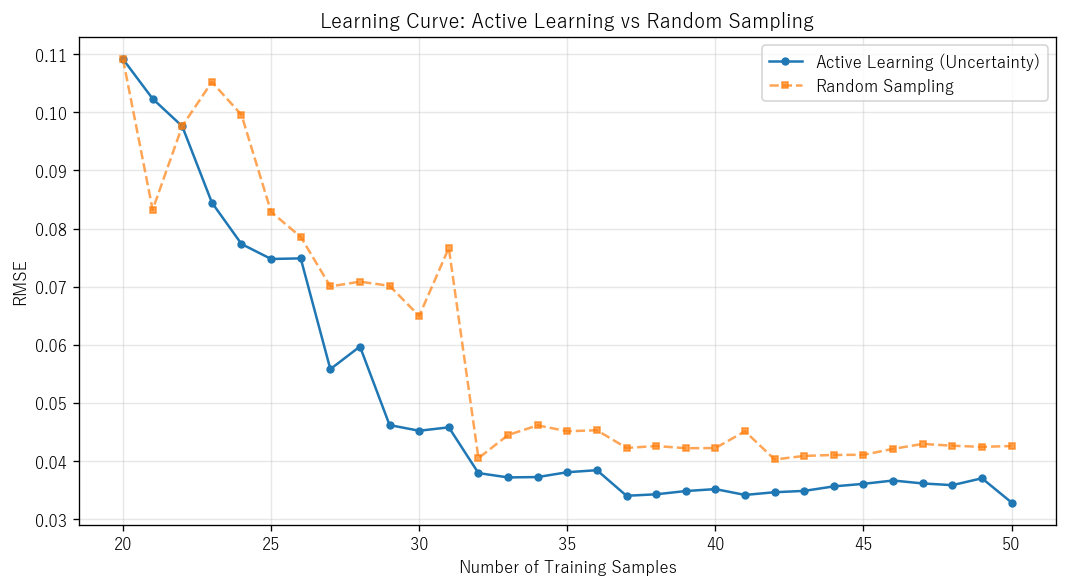


最終RMSE比較 (50 samples)
  Active Learning:  0.0329
  Random Sampling:  0.0426
  Improvement:      +22.8%


In [48]:
# RMSE学習曲線の比較
n_samples = np.arange(initial["X"].shape[0],
                      initial["X"].shape[0] + N_ITERATIONS + 1)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(n_samples, al_result["rmse_history"], "o-", label="Active Learning (Uncertainty)", markersize=4)
ax.plot(n_samples, rand_result["rmse_history"], "s--", label="Random Sampling", markersize=4, alpha=0.7)
ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("RMSE")
ax.set_title("Learning Curve: Active Learning vs Random Sampling")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'':=<50}")
print(f"最終RMSE比較 ({n_samples[-1]} samples)")
print(f"{'':=<50}")
print(f"  Active Learning:  {al_result['rmse_history'][-1]:.4f}")
print(f"  Random Sampling:  {rand_result['rmse_history'][-1]:.4f}")
improvement = (1 - al_result['rmse_history'][-1] / rand_result['rmse_history'][-1]) * 100
print(f"  Improvement:      {improvement:+.1f}%")

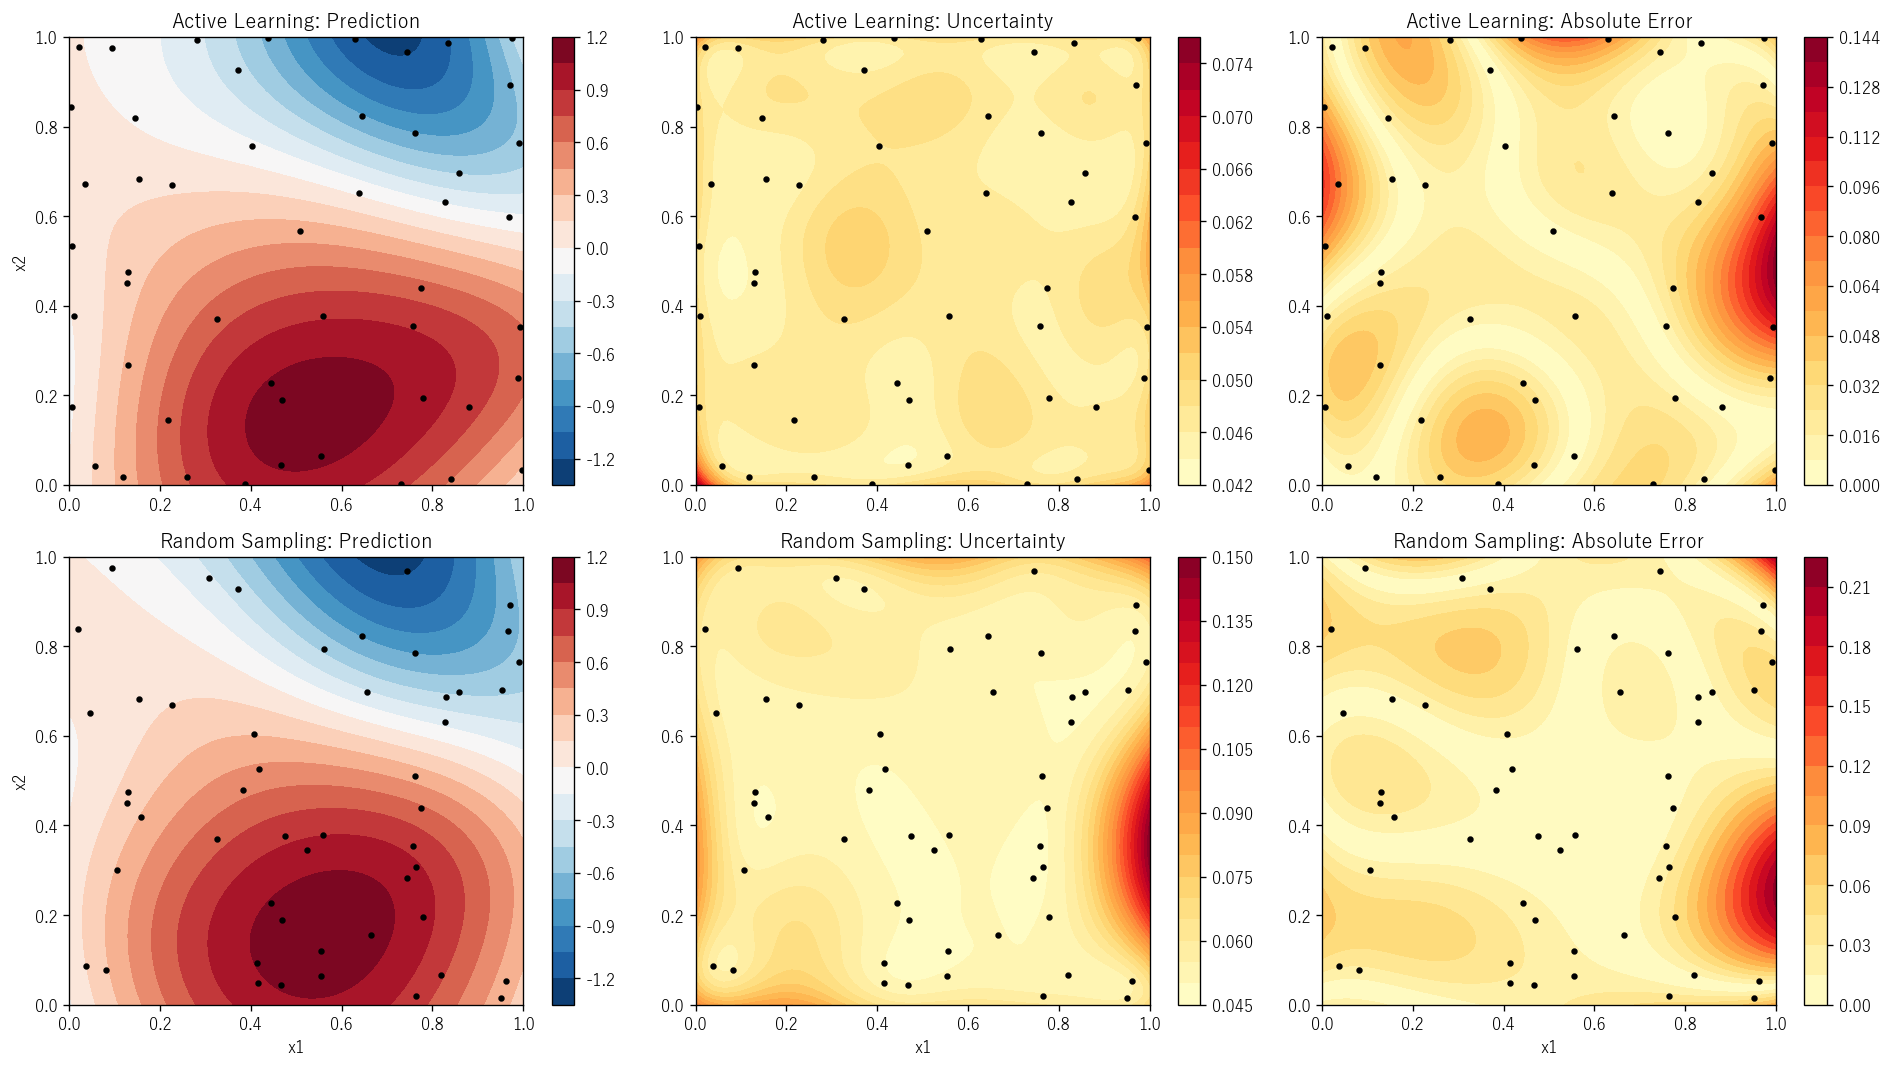

In [49]:
# 最終モデルの比較（能動学習 vs ランダム）
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for row, (result, label) in enumerate([
    (al_result, "Active Learning"),
    (rand_result, "Random Sampling"),
]):
    gpr = result["gpr_final"]
    X_train = result["X_train_final"]
    X_flat = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
    y_pred, y_std = gpr.predict(X_flat, return_std=True)

    Y_pred = y_pred.reshape(X1_grid.shape)
    Y_std = y_std.reshape(X1_grid.shape)
    Y_err = np.abs(Y_pred - Y_grid)

    ax = axes[row, 0]
    c = ax.contourf(X1_grid, X2_grid, Y_pred, levels=20, cmap="RdBu_r")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=8, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title(f"{label}: Prediction")
    ax.set_ylabel("x2")

    ax = axes[row, 1]
    c = ax.contourf(X1_grid, X2_grid, Y_std, levels=20, cmap="YlOrRd")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=8, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title(f"{label}: Uncertainty")

    ax = axes[row, 2]
    c = ax.contourf(X1_grid, X2_grid, Y_err, levels=20, cmap="YlOrRd")
    ax.scatter(X_train[:, 0], X_train[:, 1], c="k", s=8, zorder=5)
    fig.colorbar(c, ax=ax)
    ax.set_title(f"{label}: Absolute Error")

for ax in axes[1]:
    ax.set_xlabel("x1")
axes[0, 0].set_ylabel("x2"); axes[1, 0].set_ylabel("x2")

plt.tight_layout()
plt.show()

## 8. 追加モデルによる能動学習

ガウス過程回帰（GPR）以外のモデルを用いた能動学習を実装します。

| 手法 | 不確実性の推定方法 |
|------|----------------|
| **決定木** (DT) | 葉ノード内の訓練サンプル分散 |
| **ランダムフォレスト** (RF) | 木間の予測標準偏差 |
| **SVM** (SVR) | ブートストラップアンサンブルの予測標準偏差 |

In [50]:
# ─── 決定木（Decision Tree）────────────────────────────────────────────────

def build_dt(X_train, y_train):
    """決定木回帰モデルを構築・学習する"""
    dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=3, random_state=42)
    dt.fit(X_train, y_train)
    return dt


def dt_uncertainty(model, X_pool, X_train, y_train):
    """葉ノード内の訓練サンプル分散を不確実性として返す"""
    leaf_pool  = model.apply(X_pool)
    leaf_train = model.apply(X_train)
    leaf_var = {
        leaf: np.var(y_train[leaf_train == leaf])
        for leaf in np.unique(leaf_train)
    }
    return np.array([leaf_var.get(idx, 0.0) for idx in leaf_pool])


# ─── ランダムフォレスト（Random Forest）────────────────────────────────────

def build_rf(X_train, y_train):
    """ランダムフォレスト回帰モデルを構築・学習する"""
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    return rf


def rf_uncertainty(model, X_pool, X_train=None, y_train=None):
    """木間の予測標準偏差を不確実性として返す"""
    tree_preds = np.array([tree.predict(X_pool) for tree in model.estimators_])
    return tree_preds.std(axis=0)


# ─── SVM（SVR ブートストラップアンサンブル）────────────────────────────────

class SVRBootstrap:
    """Bootstrap アンサンブルによる不確実性付き SVR"""

    def __init__(self, n_bootstrap=15, random_state=42):
        self.n_bootstrap = n_bootstrap
        self.random_state = random_state

    def fit(self, X_train, y_train):
        rng = np.random.default_rng(self.random_state)
        n = len(X_train)
        self.models_  = []
        self.scalers_ = []
        for _ in range(self.n_bootstrap):
            idx = rng.integers(0, n, size=n)
            scaler = StandardScaler()
            Xs = scaler.fit_transform(X_train[idx])
            svr = SVR(kernel="rbf", C=1.0, epsilon=0.1)
            svr.fit(Xs, y_train[idx])
            self.models_.append(svr)
            self.scalers_.append(scaler)
        return self

    def _all_preds(self, X):
        return np.array([
            m.predict(sc.transform(X))
            for m, sc in zip(self.models_, self.scalers_)
        ])

    def predict(self, X):
        return self._all_preds(X).mean(axis=0)

    def predict_std(self, X):
        p = self._all_preds(X)
        return p.mean(axis=0), p.std(axis=0)


def build_svr(X_train, y_train):
    """SVR ブートストラップアンサンブルを構築・学習する"""
    return SVRBootstrap(n_bootstrap=15).fit(X_train, y_train)


def svr_uncertainty(model, X_pool, X_train=None, y_train=None):
    """ブートストラップ間の予測標準偏差を不確実性として返す"""
    _, std = model.predict_std(X_pool)
    return std


# ─── 汎用能動学習ループ ─────────────────────────────────────────────────────

def active_learning_loop_generic(
    X_init, y_init, X_pool, y_pool, X_eval, y_eval,
    model_builder, uncertainty_fn,
    n_iterations=30, batch_size=1
):
    """
    任意のモデル／不確実性関数に対応した能動学習ループ

    Parameters
    ----------
    model_builder  : (X_train, y_train) → fitted model
    uncertainty_fn : (model, X_pool, X_train, y_train) → 1d uncertainty array
    """
    X_train = X_init.copy(); y_train = y_init.copy()
    X_remaining = X_pool.copy(); y_remaining = y_pool.copy()
    rmse_history, selected_points = [], []

    for _ in range(n_iterations):
        model = model_builder(X_train, y_train)
        rmse_history.append(evaluate_model(model, X_eval, y_eval))

        uncertainty = uncertainty_fn(model, X_remaining, X_train, y_train)
        idx = np.argsort(uncertainty)[-batch_size:]

        selected_points.append(X_remaining[idx].copy())
        X_train = np.vstack([X_train, X_remaining[idx]])
        y_train = np.concatenate([y_train, y_remaining[idx]])
        X_remaining = np.delete(X_remaining, idx, axis=0)
        y_remaining = np.delete(y_remaining, idx, axis=0)

    model_final = model_builder(X_train, y_train)
    rmse_history.append(evaluate_model(model_final, X_eval, y_eval))

    return dict(
        rmse_history=rmse_history,
        selected_points=selected_points,
        model_final=model_final,
        X_train_final=X_train,
        y_train_final=y_train,
    )

In [51]:
print("▶ 決定木ベースの能動学習を実行中...")
dt_result = active_learning_loop_generic(
    initial["X"], initial["y"], pool["X"], pool["y"], X_grid_flat, y_grid_flat,
    model_builder=build_dt, uncertainty_fn=dt_uncertainty,
    n_iterations=N_ITERATIONS,
)
print(f"  DT   RMSE: {dt_result['rmse_history'][0]:.4f} → {dt_result['rmse_history'][-1]:.4f}")

print("▶ ランダムフォレストベースの能動学習を実行中...")
rf_result = active_learning_loop_generic(
    initial["X"], initial["y"], pool["X"], pool["y"], X_grid_flat, y_grid_flat,
    model_builder=build_rf, uncertainty_fn=rf_uncertainty,
    n_iterations=N_ITERATIONS,
)
print(f"  RF   RMSE: {rf_result['rmse_history'][0]:.4f} → {rf_result['rmse_history'][-1]:.4f}")

print("▶ SVMベースの能動学習を実行中... (やや時間がかかります)")
svr_result = active_learning_loop_generic(
    initial["X"], initial["y"], pool["X"], pool["y"], X_grid_flat, y_grid_flat,
    model_builder=build_svr, uncertainty_fn=svr_uncertainty,
    n_iterations=N_ITERATIONS,
)
print(f"  SVR  RMSE: {svr_result['rmse_history'][0]:.4f} → {svr_result['rmse_history'][-1]:.4f}")

print("\n完了！")

▶ 決定木ベースの能動学習を実行中...
  DT   RMSE: 0.5034 → 0.2885
▶ ランダムフォレストベースの能動学習を実行中...
  RF   RMSE: 0.2969 → 0.1478
▶ SVMベースの能動学習を実行中... (やや時間がかかります)
  SVR  RMSE: 0.1088 → 0.0891

完了！


## 9. 4手法の比較（vs ランダムサンプリング）

各能動学習手法の学習曲線をランダムサンプリングと比較します。

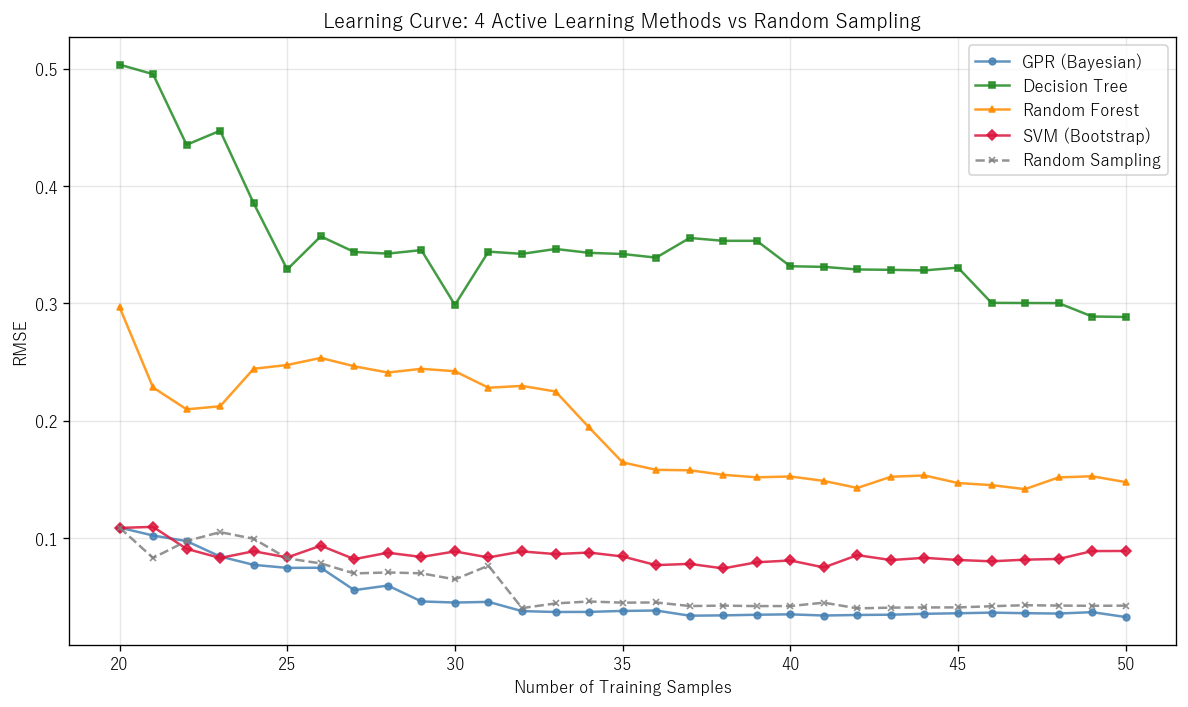


最終RMSE比較 (50 samples)
  GPR (Bayesian)           : 0.0329  (改善率: +22.8%)
  Decision Tree            : 0.2885  (改善率: -577.2%)
  Random Forest            : 0.1478  (改善率: -247.0%)
  SVM (Bootstrap)          : 0.0891  (改善率: -109.3%)
  Random Sampling          : 0.0426  (改善率: +0.0%)


In [52]:
fig, ax = plt.subplots(figsize=(10, 6))

method_plots = [
    (al_result,   "GPR (Bayesian)",   "o-",  "steelblue"),
    (dt_result,   "Decision Tree",    "s-",  "forestgreen"),
    (rf_result,   "Random Forest",    "^-",  "darkorange"),
    (svr_result,  "SVM (Bootstrap)",  "D-",  "crimson"),
    (rand_result, "Random Sampling",  "x--", "gray"),
]

for result, label, marker, color in method_plots:
    ax.plot(n_samples, result["rmse_history"], marker,
            label=label, color=color, markersize=4, alpha=0.85)

ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("RMSE")
ax.set_title("Learning Curve: 4 Active Learning Methods vs Random Sampling")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'':=<60}")
print(f"最終RMSE比較 ({n_samples[-1]} samples)")
print(f"{'':=<60}")
rand_final = rand_result["rmse_history"][-1]
for result, label, _, _ in method_plots:
    final = result["rmse_history"][-1]
    imp   = (1 - final / rand_final) * 100
    print(f"  {label:<25}: {final:.4f}  (改善率: {imp:+.1f}%)")

## 10. アンサンブル能動学習

4手法の不確実性を正規化・平均して獲得関数とする**統合アンサンブル手法**を実装します。

$$\text{統合不確実性}(x) = \frac{
  \hat{\sigma}_{\text{GPR}}(x) + \hat{\sigma}_{\text{DT}}(x) +
  \hat{\sigma}_{\text{RF}}(x) + \hat{\sigma}_{\text{SVM}}(x)
}{4}$$

$\hat{\sigma}$ は各手法の不確実性を $[0, 1]$ に正規化したものです。  
単一手法のバイアスを相殺し、頑健なサンプリングが期待できます。

In [53]:
def _normalize(u):
    """0–1 正規化"""
    r = u.max() - u.min()
    return (u - u.min()) / (r + 1e-10)


def active_learning_loop_ensemble(
    X_init, y_init, X_pool, y_pool, X_eval, y_eval,
    n_iterations=30, batch_size=1
):
    """4手法アンサンブルによる能動学習ループ"""
    X_train = X_init.copy(); y_train = y_init.copy()
    X_remaining = X_pool.copy(); y_remaining = y_pool.copy()
    rmse_history, selected_points = [], []

    for _ in range(n_iterations):
        # ① 4モデルを構築
        gpr = build_gpr(X_train, y_train)
        dt  = build_dt(X_train, y_train)
        rf  = build_rf(X_train, y_train)
        svr = build_svr(X_train, y_train)

        # ② アンサンブル平均予測で RMSE 計算
        ens_pred = np.mean([
            gpr.predict(X_eval),
            dt.predict(X_eval),
            rf.predict(X_eval),
            svr.predict(X_eval),
        ], axis=0)
        rmse_history.append(np.sqrt(mean_squared_error(y_eval, ens_pred)))

        # ③ 各手法の不確実性を正規化・統合
        _, gpr_std = gpr.predict(X_remaining, return_std=True)
        combined = (
            _normalize(gpr_std)
            + _normalize(dt_uncertainty(dt, X_remaining, X_train, y_train))
            + _normalize(rf_uncertainty(rf, X_remaining))
            + _normalize(svr_uncertainty(svr, X_remaining))
        ) / 4

        idx = np.argsort(combined)[-batch_size:]
        selected_points.append(X_remaining[idx].copy())
        X_train = np.vstack([X_train, X_remaining[idx]])
        y_train = np.concatenate([y_train, y_remaining[idx]])
        X_remaining = np.delete(X_remaining, idx, axis=0)
        y_remaining = np.delete(y_remaining, idx, axis=0)

    # 最終評価
    gpr = build_gpr(X_train, y_train)
    dt  = build_dt(X_train, y_train)
    rf  = build_rf(X_train, y_train)
    svr = build_svr(X_train, y_train)
    ens_pred = np.mean([
        gpr.predict(X_eval), dt.predict(X_eval),
        rf.predict(X_eval),  svr.predict(X_eval),
    ], axis=0)
    rmse_history.append(np.sqrt(mean_squared_error(y_eval, ens_pred)))

    return dict(
        rmse_history=rmse_history,
        selected_points=selected_points,
        X_train_final=X_train,
        y_train_final=y_train,
    )


print("▶ アンサンブル能動学習を実行中... (各反復で4モデルを構築します)")
ensemble_result = active_learning_loop_ensemble(
    initial["X"], initial["y"], pool["X"], pool["y"],
    X_grid_flat, y_grid_flat,
    n_iterations=N_ITERATIONS,
)
print(f"  Ensemble RMSE: {ensemble_result['rmse_history'][0]:.4f} → {ensemble_result['rmse_history'][-1]:.4f}")
print("完了！")

▶ アンサンブル能動学習を実行中... (各反復で4モデルを構築します)
  Ensemble RMSE: 0.1971 → 0.0870
完了！


## 11. 全手法の最終比較

5つの能動学習手法（GPR・決定木・ランダムフォレスト・SVM・アンサンブル）とランダムサンプリングを一括比較します。

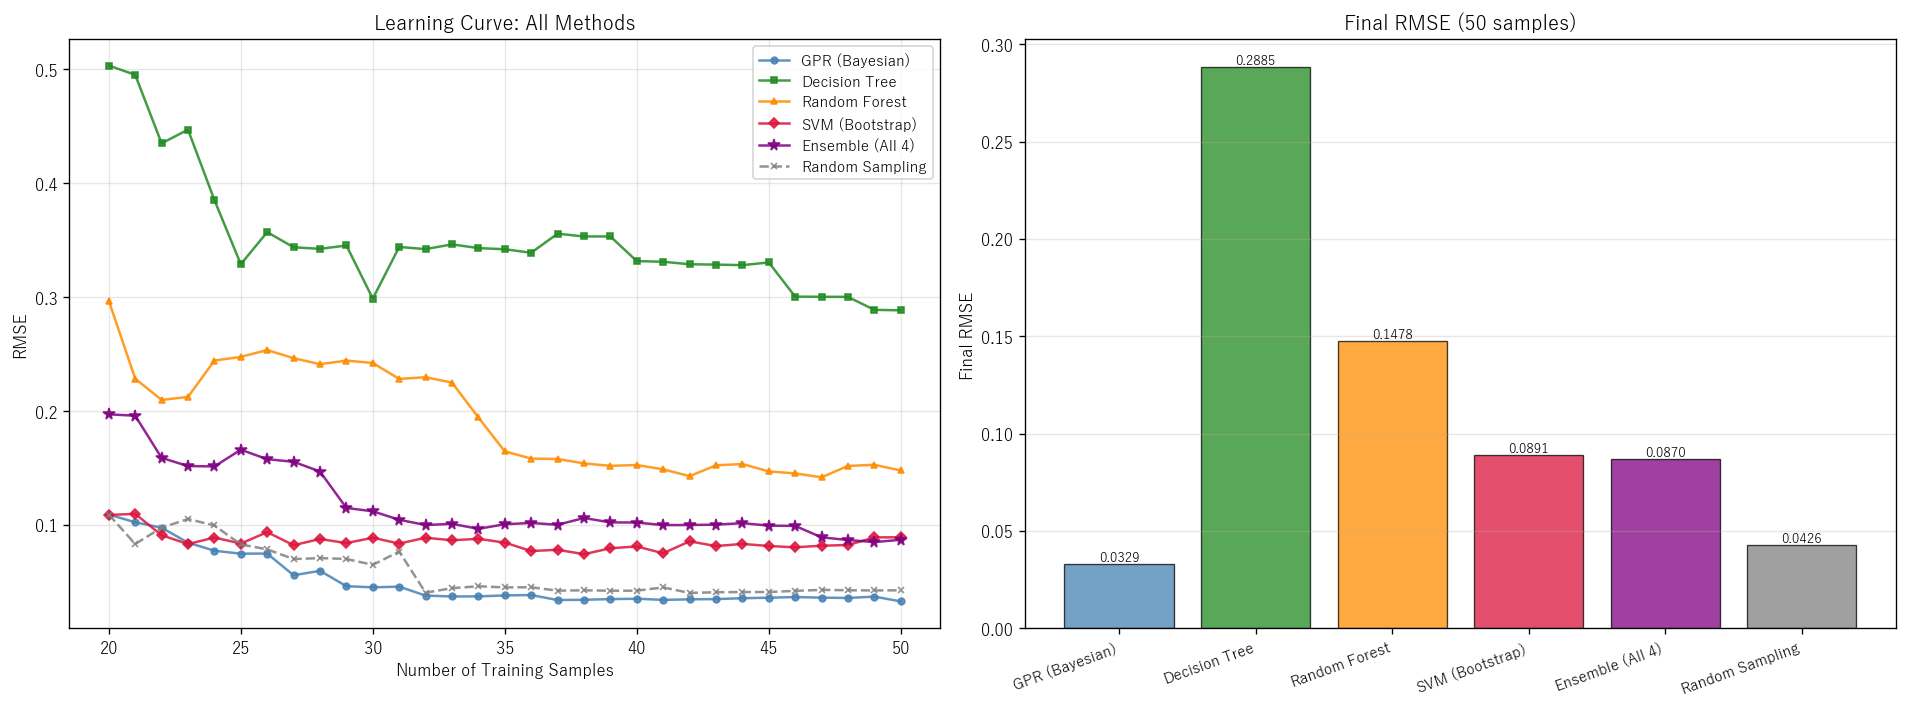


手法                               最終RMSE         対ランダム改善率
  GPR (Bayesian)            :     0.0329           +22.8% ★ Best
  Decision Tree             :     0.2885          -577.2%
  Random Forest             :     0.1478          -247.0%
  SVM (Bootstrap)           :     0.0891          -109.3%
  Ensemble (All 4)          :     0.0870          -104.1%
  Random Sampling           :     0.0426            +0.0%


In [54]:
# 全手法 + ランダムの学習曲線比較
all_methods = [
    (al_result,       "GPR (Bayesian)",   "o-",  "steelblue"),
    (dt_result,       "Decision Tree",    "s-",  "forestgreen"),
    (rf_result,       "Random Forest",    "^-",  "darkorange"),
    (svr_result,      "SVM (Bootstrap)",  "D-",  "crimson"),
    (ensemble_result, "Ensemble (All 4)", "*-",  "purple"),
    (rand_result,     "Random Sampling",  "x--", "gray"),
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- 左: 学習曲線 ---
ax = axes[0]
for result, label, marker, color in all_methods:
    ms = 7 if "*" in marker else 4
    ax.plot(n_samples, result["rmse_history"], marker,
            label=label, color=color, markersize=ms, alpha=0.85, linewidth=1.5)
ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("RMSE")
ax.set_title("Learning Curve: All Methods")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- 右: 最終RMSE棒グラフ ---
ax = axes[1]
names  = [label for _, label, _, _ in all_methods]
finals = [r["rmse_history"][-1] for r, *_ in all_methods]
colors = [c for _, _, _, c in all_methods]
bars = ax.bar(names, finals, color=colors, alpha=0.75, edgecolor="k", linewidth=0.8)
ax.set_ylabel("Final RMSE")
ax.set_title(f"Final RMSE ({n_samples[-1]} samples)")
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=20, ha="right", fontsize=9)
ax.grid(True, alpha=0.3, axis="y")
for bar, val in zip(bars, finals):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0005,
            f"{val:.4f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

# --- テーブル ---
print(f"\n{'':=<65}")
print(f"{'手法':<28} {'最終RMSE':>10}  {'対ランダム改善率':>15}")
print(f"{'':=<65}")
rand_final = rand_result["rmse_history"][-1]
best_rmse  = min(r["rmse_history"][-1] for r, *_ in all_methods[:-1])
for result, label, _, _ in all_methods:
    final = result["rmse_history"][-1]
    imp   = (1 - final / rand_final) * 100
    star  = " ★ Best" if abs(final - best_rmse) < 1e-6 else ""
    print(f"  {label:<26}: {final:>10.4f}  {imp:>+14.1f}%{star}")

## 7. まとめ

### 観察されたこと

1. **学習曲線**: 能動学習はランダムサンプリングよりも少ないデータで低いRMSEを達成
2. **サンプル選択**: 能動学習は初期段階ではデータの空白地帯を、後半では関数の変動が大きい領域を重点的にサンプリング
3. **不確実性**: 能動学習後は全体的に不確実性が均一に低下。ランダムでは偏りが残る

### 能動学習の利点

- シミュレーション回数（＝コスト）を削減しつつ、サロゲートモデルの精度を確保
- 「どこを実験すべきか」の意思決定を自動化

### 発展的な話題

- **Bayesian Optimization**: 不確実性の低減ではなく、目的関数の最適値探索に特化した能動学習
- **バッチ能動学習**: 一度に複数点を選択（並列実験に対応）
- **多目的能動学習**: 複数の性能指標を同時に考慮

## 12. 複数データセットによる公平な比較

前節の比較には 2 つの構造的な問題がありました。

| 問題 | 内容 |
|------|------|
| **評価の混同** | 各サロゲートモデル自身の RMSE を比較 → 「AL 戦略の良さ」と「モデルの予測精度」が分離できない |
| **データの偏り** | 滑らかな正弦波関数は GPR/SVR 有利、決定木には不利 |

### 改善策

1. **3 種類のデータセット**で各手法の有利・不利条件を網羅する
2. **共通評価モデル（k 近傍回帰 KNN）**で「どの点を選んだか」だけを公平に比較する

| データセット | 関数の性質 | 理論上の有利手法 |
|---|---|---|
| **Smooth (sin/cos)** | 全域微分可能な滑らかな関数 | GPR / SVR |
| **Piecewise (abs)** | 連続だが折れ線状（非微分点あり） | DT / RF |
| **Stepwise (sign)** | 不連続・軸平行な境界 | DT |

### 評価の考え方

```
各AL手法 → N点を選択 → 【共通KNNで評価】（全手法で同一の評価器）
```

これにより「GPRが滑らかな関数の近似が得意」というモデルの優位性を除外し、**純粋に「どこをサンプリングしたか」** の優劣を比較できます。

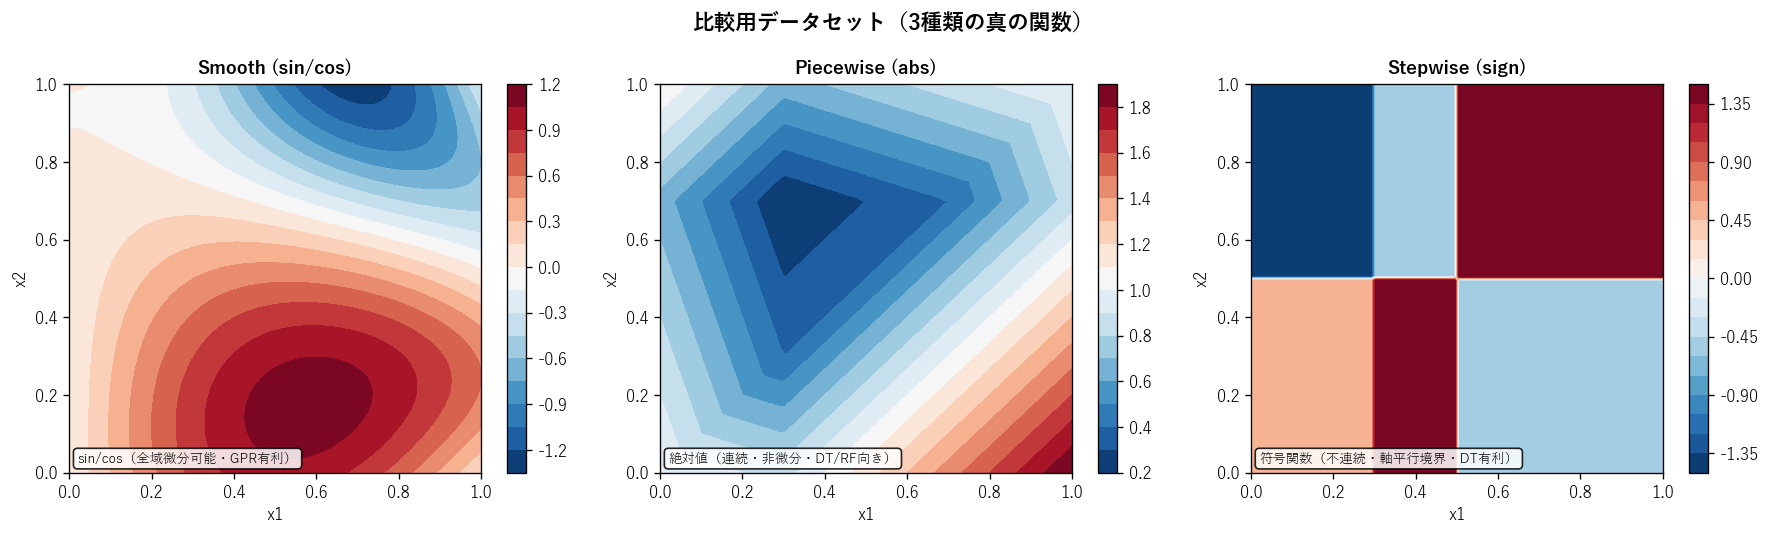

In [55]:
# ─── 3種類の真の関数定義 ─────────────────────────────────────────────────────
DATASET_DEFS = {
    "Smooth (sin/cos)": {
        "func": lambda x1, x2: np.sin(3*x1)*np.cos(3*x2) + 0.5*np.sin(6*x1*x2),
        "desc": "sin/cos（全域微分可能・GPR有利）",
    },
    "Piecewise (abs)": {
        "func": lambda x1, x2: np.abs(x1 - 0.3) + np.abs(x2 - 0.7) + 0.5*np.abs(x1 - x2),
        "desc": "絶対値（連続・非微分・DT/RF向き）",
    },
    "Stepwise (sign)": {
        "func": lambda x1, x2: (
            np.sign(x1 - 0.5).astype(float) * np.sign(x2 - 0.5).astype(float)
            + 0.5 * np.sign(x1 - 0.3).astype(float)
        ),
        "desc": "符号関数（不連続・軸平行境界・DT有利）",
    },
}


def generate_dataset_from_func(func, seed=42, n_initial=20, n_pool=500,
                                n_grid=100, noise_std=0.05):
    """任意の真の関数からデータセットを生成する"""
    rng_init = np.random.default_rng(seed)
    rng_pool = np.random.default_rng(seed + 1)

    x1v = np.linspace(0, 1, n_grid)
    x2v = np.linspace(0, 1, n_grid)
    X1, X2 = np.meshgrid(x1v, x2v)
    Xg = np.column_stack([X1.ravel(), X2.ravel()])
    yg = func(Xg[:, 0], Xg[:, 1]).astype(float)

    Xi = rng_init.uniform(0, 1, (n_initial, 2))
    yi = func(Xi[:, 0], Xi[:, 1]).astype(float) + rng_init.normal(0, noise_std, n_initial)

    Xp = rng_pool.uniform(0, 1, (n_pool, 2))
    yp = func(Xp[:, 0], Xp[:, 1]).astype(float) + rng_pool.normal(0, noise_std, n_pool)

    return dict(
        X1=X1, X2=X2, Y_grid=yg.reshape(n_grid, n_grid),
        X_grid_flat=Xg, y_grid_flat=yg,
        X_init=Xi, y_init=yi,
        X_pool=Xp, y_pool=yp,
    )


def evaluate_strategy_fair(X_train, y_train, X_eval, y_eval, k=5):
    """
    共通評価モデル（k近傍回帰）によるAL戦略の公平評価。
    すべての手法に同じ評価器を適用し「どの点を選んだか」だけを比較する。
    """
    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors=min(k, len(X_train)), weights="distance")
    knn.fit(X_train, y_train)
    return np.sqrt(mean_squared_error(y_eval, knn.predict(X_eval)))


# ─── データセット可視化 ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
for ax, (name, meta) in zip(axes, DATASET_DEFS.items()):
    ds = generate_dataset_from_func(meta["func"])
    c = ax.contourf(ds["X1"], ds["X2"], ds["Y_grid"], levels=20, cmap="RdBu_r")
    fig.colorbar(c, ax=ax)
    ax.set_title(name, fontsize=11, fontweight="bold")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax.text(0.02, 0.02, meta["desc"], transform=ax.transAxes, fontsize=8,
            va="bottom", bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.85))
fig.suptitle("比較用データセット（3種類の真の関数）", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

In [56]:
N_ITER_MULTI = 30


def gpr_uncertainty(model, X_pool, X_train=None, y_train=None):
    """GPRの予測標準偏差を不確実性として返す"""
    _, std = model.predict(X_pool, return_std=True)
    return std


AL_METHODS_DICT = {
    "GPR (Bayesian)":  (build_gpr,  gpr_uncertainty),
    "Decision Tree":   (build_dt,   dt_uncertainty),
    "Random Forest":   (build_rf,   rf_uncertainty),
    "SVM (Bootstrap)": (build_svr,  svr_uncertainty),
}


def run_random_sampling(ds, n_iterations=30, seed=0):
    """ランダムサンプリング（モデル不要・サロゲートなし）"""
    rng = np.random.default_rng(seed)
    X_train = ds["X_init"].copy()
    y_train = ds["y_init"].copy()
    X_rem = ds["X_pool"].copy()
    y_rem  = ds["y_pool"].copy()
    for _ in range(n_iterations):
        idx = int(rng.integers(0, len(X_rem)))
        X_train = np.vstack([X_train, X_rem[[idx]]])
        y_train = np.concatenate([y_train, y_rem[[idx]]])
        X_rem = np.delete(X_rem, idx, axis=0)
        y_rem  = np.delete(y_rem, idx)
    return X_train, y_train


# ─── 全データセット × 全手法を実行 ───────────────────────────────────────────
all_results = {}

for ds_name, ds_meta in DATASET_DEFS.items():
    print(f"\n{'':=<55}")
    print(f"Dataset: {ds_name}")
    print(f"{'':=<55}")
    ds = generate_dataset_from_func(ds_meta["func"])
    all_results[ds_name] = {}

    # 4つの能動学習手法
    for method_name, (builder, unc_fn) in AL_METHODS_DICT.items():
        print(f"  {method_name:<22}...", end=" ", flush=True)
        result = active_learning_loop_generic(
            ds["X_init"], ds["y_init"],
            ds["X_pool"], ds["y_pool"],
            ds["X_grid_flat"], ds["y_grid_flat"],
            model_builder=builder,
            uncertainty_fn=unc_fn,
            n_iterations=N_ITER_MULTI,
        )
        fair_rmse = evaluate_strategy_fair(
            result["X_train_final"], result["y_train_final"],
            ds["X_grid_flat"], ds["y_grid_flat"],
        )
        all_results[ds_name][method_name] = {
            "fair_rmse":   fair_rmse,
            "own_history": result["rmse_history"],   # サロゲート自身のRMSE推移
            "X_train":     result["X_train_final"],
        }
        print(f"own={result['rmse_history'][-1]:.4f}  fair_knn={fair_rmse:.4f}")

    # ランダムベースライン（サロゲートなし）
    print(f"  {'Random':<22}...", end=" ", flush=True)
    X_rand, y_rand = run_random_sampling(ds, n_iterations=N_ITER_MULTI)
    fair_rmse = evaluate_strategy_fair(X_rand, y_rand, ds["X_grid_flat"], ds["y_grid_flat"])
    all_results[ds_name]["Random"] = {
        "fair_rmse": fair_rmse,
        "X_train":   X_rand,
    }
    print(f"fair_knn={fair_rmse:.4f}")

print("\n全データセット × 全手法の実行完了！")


Dataset: Smooth (sin/cos)
  GPR (Bayesian)        ... own=0.0329  fair_knn=0.0836
  Decision Tree         ... own=0.2885  fair_knn=0.1494
  Random Forest         ... own=0.1478  fair_knn=0.1153
  SVM (Bootstrap)       ... own=0.0891  fair_knn=0.1800
  Random                ... fair_knn=0.1204

Dataset: Piecewise (abs)
  GPR (Bayesian)        ... own=0.0460  fair_knn=0.1038
  Decision Tree         ... own=0.1611  fair_knn=0.0857
  Random Forest         ... own=0.1780  fair_knn=0.1804
  SVM (Bootstrap)       ... own=0.0626  fair_knn=0.1086
  Random                ... fair_knn=0.0995

Dataset: Stepwise (sign)
  GPR (Bayesian)        ... 

d:\workspace\65.active_learning\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


own=0.5440  fair_knn=0.5011
  Decision Tree         ... own=0.9474  fair_knn=0.5537
  Random Forest         ... own=0.2798  fair_knn=0.5702
  SVM (Bootstrap)       ... own=0.6117  fair_knn=0.5530
  Random                ... fair_knn=0.4878

全データセット × 全手法の実行完了！


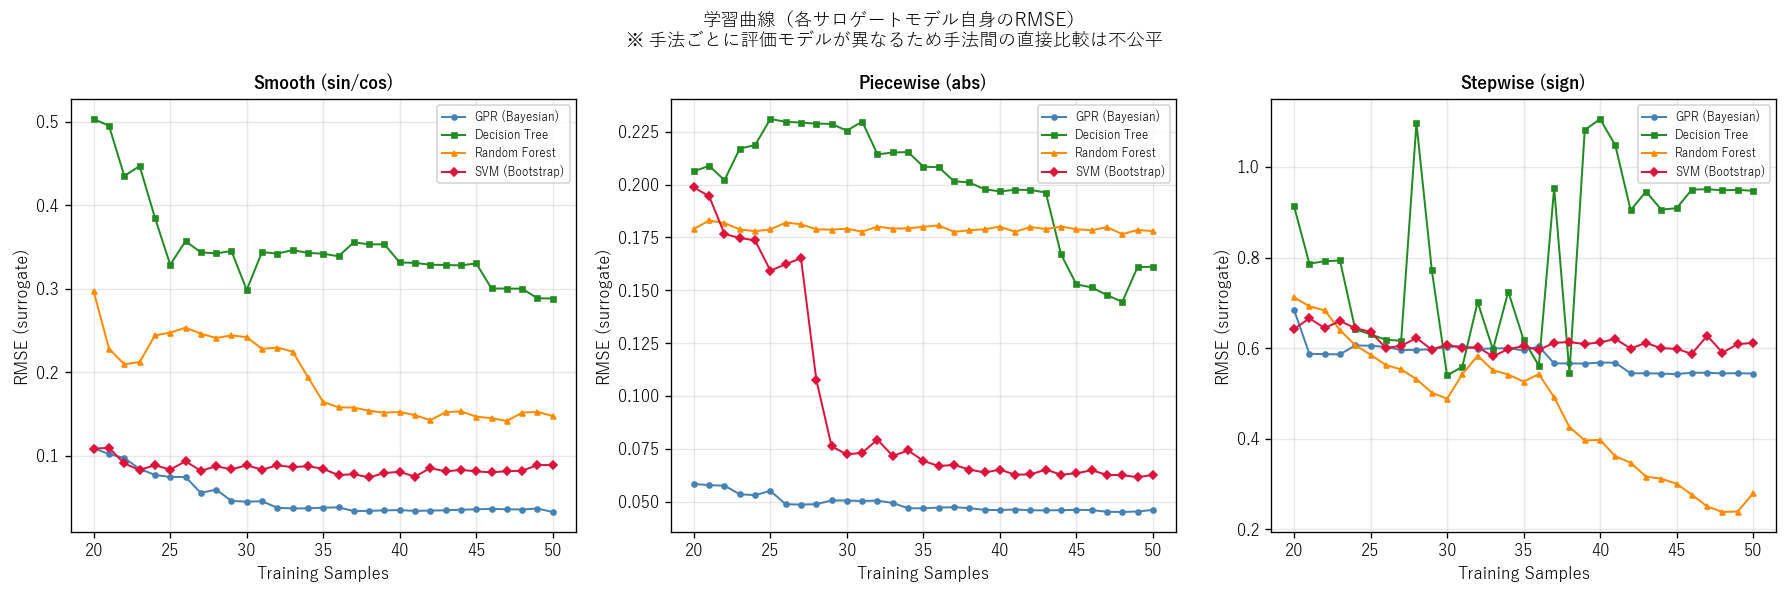

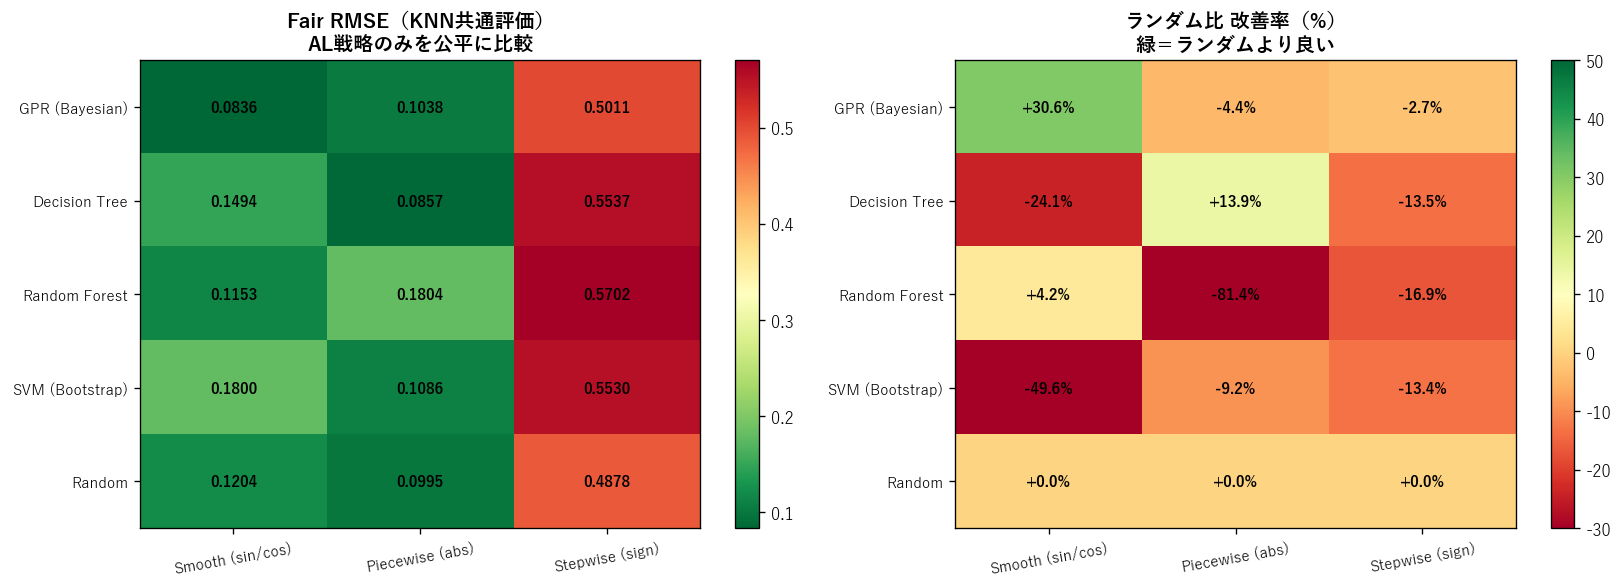


Fair RMSE（KNN共通評価）: AL戦略のみの公平な比較
  手法                         Smooth (sin/cos)   Piecewise (abs)   Stepwise (sign)
  GPR (Bayesian)                       0.0836            0.1038            0.5011
  Decision Tree                        0.1494            0.0857            0.5537
  Random Forest                        0.1153            0.1804            0.5702
  SVM (Bootstrap)                      0.1800            0.1086            0.5530
  Random                               0.1204            0.0995            0.4878

[解釈のポイント]
  Smooth  : GPR/SVMが有利なはず（滑らか関数 ≒ RBFカーネルの仮定と一致）
  Piecewise: DT/RFが有利なはず（折れ線 ≒ 軸平行分割で近似しやすい）
  Stepwise : DTが最有利なはず（不連続・軸平行境界 ≒ 決定木の仮定と完全一致）


In [57]:
n_samples_multi = np.arange(20, 20 + N_ITER_MULTI + 1)

method_styles = {
    "GPR (Bayesian)":  ("steelblue",   "o-"),
    "Decision Tree":   ("forestgreen", "s-"),
    "Random Forest":   ("darkorange",  "^-"),
    "SVM (Bootstrap)": ("crimson",     "D-"),
}
al_method_names  = list(method_styles.keys())
all_method_names = al_method_names + ["Random"]

# ─── 1. 学習曲線（各サロゲートモデル自身のRMSE） ─────────────────────────────
fig, axes = plt.subplots(1, len(DATASET_DEFS), figsize=(15, 5), sharey=False)
for ax, ds_name in zip(axes, DATASET_DEFS):
    for method_name in al_method_names:
        res = all_results[ds_name][method_name]
        color, marker = method_styles[method_name]
        ax.plot(n_samples_multi, res["own_history"], marker,
                label=method_name, color=color, markersize=3, linewidth=1.2)
    ax.set_title(ds_name, fontsize=10, fontweight="bold")
    ax.set_xlabel("Training Samples")
    ax.set_ylabel("RMSE (surrogate)")
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
fig.suptitle(
    "学習曲線（各サロゲートモデル自身のRMSE）\n"
    "※ 手法ごとに評価モデルが異なるため手法間の直接比較は不公平",
    fontsize=11)
plt.tight_layout()
plt.show()

# ─── 2. Fair KNN RMSE ヒートマップ ──────────────────────────────────────────
ds_labels = list(DATASET_DEFS.keys())
fair_matrix = np.array([
    [all_results[ds][m]["fair_rmse"] for ds in DATASET_DEFS]
    for m in all_method_names
])
rand_row = fair_matrix[all_method_names.index("Random")]
improvement_matrix = (1 - fair_matrix / rand_row[None, :]) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, data, fmt, title, cmap, vmin, vmax in [
    (axes[0], fair_matrix, "{:.4f}",
     "Fair RMSE（KNN共通評価）\nAL戦略のみを公平に比較", "RdYlGn_r", None, None),
    (axes[1], improvement_matrix, "{:+.1f}%",
     "ランダム比 改善率（%）\n緑＝ランダムより良い", "RdYlGn", -30, 50),
]:
    im = ax.imshow(data, cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks(range(len(ds_labels)))
    ax.set_xticklabels(ds_labels, fontsize=9, rotation=10)
    ax.set_yticks(range(len(all_method_names)))
    ax.set_yticklabels(all_method_names, fontsize=9)
    for i in range(len(all_method_names)):
        for j in range(len(ds_labels)):
            ax.text(j, i, fmt.format(data[i, j]),
                    ha="center", va="center", fontsize=9, fontweight="bold")
    plt.colorbar(im, ax=ax)
    ax.set_title(title, fontweight="bold")
plt.tight_layout()
plt.show()

# ─── 3. 数値テーブル ──────────────────────────────────────────────────────────
print(f"\n{'':=<80}")
print("Fair RMSE（KNN共通評価）: AL戦略のみの公平な比較")
print(f"{'':=<80}")
print(f"  {'手法':<25}" + "".join(f"{ds:>18}" for ds in ds_labels))
print(f"{'':=<80}")
for i, method in enumerate(all_method_names):
    print(f"  {method:<25}" + "".join(f"{fair_matrix[i,j]:>18.4f}" for j in range(len(ds_labels))))
print(f"{'':=<80}")

print("\n[解釈のポイント]")
print("  Smooth  : GPR/SVMが有利なはず（滑らか関数 ≒ RBFカーネルの仮定と一致）")
print("  Piecewise: DT/RFが有利なはず（折れ線 ≒ 軸平行分割で近似しやすい）")
print("  Stepwise : DTが最有利なはず（不連続・軸平行境界 ≒ 決定木の仮定と完全一致）")